# Parameter Optimization

To decide the optimal numeric values for `MAX_VOCAB_COUNTS` and `MAX_WORD_LENGTH`, iterate some possible combinations of two variables.

In [ ]:
import os
os.chdir('/content/drive/MyDrive/colab-data/ai-final/')
print(f"Current directory is {os.getcwd()}")

Current directory is /content/drive/MyDrive/colab-data/ai-final


In [ ]:
import pandas as pd
import re
import tensorflow as tf

# Get Train Dataset
file_list = [f"amazon_review_full_csv/train/{name}"
                for name in os.listdir('amazon_review_full_csv/train')
                if re.match('^train_\d{3}\.csv$', name)]

# Mix up Test Dataset
file_list.extend([f"amazon_review_full_csv/test/{name}"
                    for name in os.listdir('amazon_review_full_csv/test')
                    if re.match('^test_\d{3}\.csv$', name)])

# TODO test
#file_list = [file_list[0]]

df_data = pd.concat([pd.read_csv(path) for path in file_list], ignore_index=True)

print(df_data.shape)

(2250000, 2)


In [ ]:
def label_score(score):
    if score == 3:
        return 1
    else:
        return 0 if score < 3 else 2

# Multiclass Classification
df_data['label'] = df_data['score'].apply(label_score)
df_data['label'].value_counts()

2    901178
0    896548
1    452274
Name: label, dtype: int64

In [ ]:
def get_tf_text(df_sample, max_vocab_count, max_word_length):
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences

    max_vocab_count = 500

    tf_tokenizer = Tokenizer(num_words=max_vocab_count, oov_token="<unk>")
    tf_tokenizer.fit_on_texts(df_sample['text'].astype(str))
    print('vocabs :', list(tf_tokenizer.word_index)[:10])

    indexed_text = tf_tokenizer.texts_to_sequences(df_sample['text'].astype(str))
    rectangularized = pad_sequences(indexed_text, maxlen=max_word_length, truncating='post')

    tf_text = tf.convert_to_tensor(rectangularized)
    print('texts :', tf_text)

    return tf_text

In [ ]:
def split_dataset(tf_text, df_sample):
    # Splitting into 6:2:2
    split1 = round(len(tf_text)*0.7)

    train_x = tf_text[:split1]
    train_y = df_sample['label'][:split1].to_list()

    val_x = tf_text[split1:]
    val_y = df_sample['label'][split1:].to_list()

    # One Hot Encoding
    train_he = tf.keras.utils.to_categorical(train_y)
    val_he = tf.keras.utils.to_categorical(val_y)

    print('train :', len(train_y), 'val :', len(val_y))

    return train_x, train_he, val_x, val_he

In [ ]:
def get_model(max_vocab_count, max_word_length):
    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(max_vocab_count, 16, input_length=max_word_length))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
def model_training(df_sample, max_vocab_count, max_word_length, epoch_count):
    tf_text = get_tf_text(df_sample, max_vocab_count, max_word_length)
    train_x, train_he, val_x, val_he = split_dataset(tf_text, df_sample)
    model = get_model(max_vocab_count, max_word_length)
    hist = model.fit(train_x, train_he, validation_data=(val_x, val_he), epochs=epoch_count)
    return hist.history

In [ ]:
def get_peak_with_index(func, arr):
    val = func(arr)
    index = arr.index(val)
    return val, index

In [ ]:
# max_word_length Comparison
ret_stats = []

sample_length = 100000
vocab_length = 700

for length in range(10, 100+1, 5):
    stats = model_training(df_data.sample(sample_length), vocab_length, length, 5)
    stats['param'] = (sample_length, vocab_length, length)
    stats['min_loss'] = get_peak_with_index(min, stats['val_loss'])
    stats['max_acc'] = get_peak_with_index(max, stats['val_accuracy'])
    ret_stats.append(stats)

In [ ]:
loss_stats = [[stat['param'][2], stat['min_loss'][0]] for stat in ret_stats]
acc_stats = [[stat['param'][2], stat['max_acc'][0]] for stat in ret_stats]

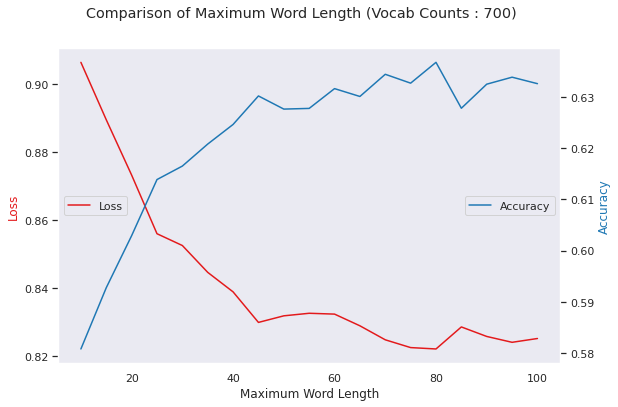

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()
sns.set_style("darkgrid", {"grid.color": "0.5"})

fig, loss_ax = plt.subplots(figsize=(9, 5.8))
acc_ax = loss_ax.twinx()

# Set title
fig.suptitle('Comparison of Maximum Word Length (Vocab Counts : 700)')

# Set X label
loss_ax.set_xlabel('Maximum Word Length')

loss_color = sns.color_palette("Paired")[5]
acc_color = sns.color_palette("Paired")[1]

sns.lineplot(x=[row[0] for row in loss_stats],
             y=[row[1] for row in loss_stats],
             ax=loss_ax, color=loss_color)

loss_ax.set_ylabel('Loss', color=loss_color)
loss_ax.legend(loc='center left', labels=['Loss'])

sns.lineplot(x=[row[0] for row in acc_stats],
             y=[row[1] for row in acc_stats],
             ax=acc_ax, color=acc_color)

acc_ax.set_ylabel('Accuracy', color=acc_color)
acc_ax.legend(loc='center right', labels=['Accuracy'])

# Remove grids
loss_ax.grid(False, axis='both')
acc_ax.grid(False, axis='both')

plt.show()


In [ ]:
# max_vocab_length Comparison
vocab_stats = []

sample_length = 100000
word_length = 80

for length in range(500, 1500+1, 100):
    stats = model_training(df_data.sample(sample_length), length, word_length, 5)
    stats['param'] = (sample_length, vocab_length, length)
    stats['min_loss'] = get_peak_with_index(min, stats['val_loss'])
    stats['max_acc'] = get_peak_with_index(max, stats['val_accuracy'])
    vocab_stats.append(stats)

loss_stats = [[stat['param'][2], stat['min_loss'][0]] for stat in vocab_stats]
acc_stats = [[stat['param'][2], stat['max_acc'][0]] for stat in vocab_stats]

['<unk>', 'good', 'like', 'great', 'read', 'time', 'buy', 'work', 'think', "'good'"]
tf.Tensor(
[[  0   0   0 ...   1   1 164]
 [  0   0   0 ...   1   1 148]
 [  0   0   0 ...   5  15   1]
 ...
 [  0   0   0 ...   1   1   1]
 [  0   0   0 ...  92 358 363]
 [  0   0   0 ... 105   1 207]], shape=(100000, 80), dtype=int32)
train : 70000 val : 30000
Epoch 1/5
2188/2188 [==============================] - 8s 4ms/step - loss: 0.9069 - accuracy: 0.5781 - val_loss: 0.8383 - val_accuracy: 0.6275
Epoch 2/5
2188/2188 [==============================] - 7s 3ms/step - loss: 0.8398 - accuracy: 0.6261 - val_loss: 0.8272 - val_accuracy: 0.6324
Epoch 3/5
2188/2188 [==============================] - 8s 3ms/step - loss: 0.8315 - accuracy: 0.6303 - val_loss: 0.8305 - val_accuracy: 0.6282
Epoch 4/5
2188/2188 [==============================] - 8s 3ms/step - loss: 0.8286 - accuracy: 0.6303 - val_loss: 0.8225 - val_accuracy: 0.6351
Epoch 5/5
2188/2188 [==============================] - 8s 4ms/step - loss: 0.826

In [ ]:
loss_stats = [[stat['param'][2], stat['min_loss'][0]] for stat in ret_stats]
acc_stats = [[stat['param'][2], stat['max_acc'][0]] for stat in ret_stats]

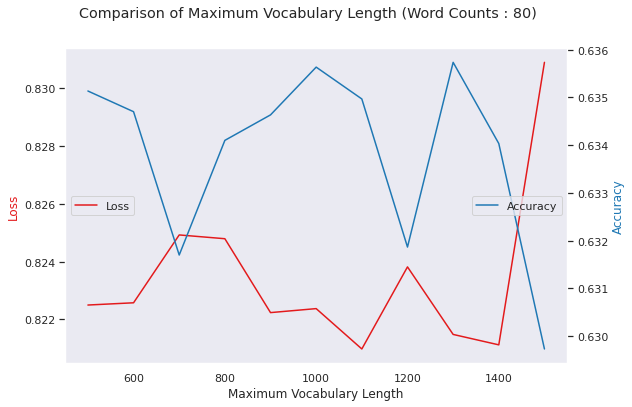

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()
sns.set_style("darkgrid", {"grid.color": "0.5"})

fig, loss_ax = plt.subplots(figsize=(9, 5.8))
acc_ax = loss_ax.twinx()

# Set title
fig.suptitle('Comparison of Maximum Vocabulary Length (Word Counts : 80)')

# Set X label
loss_ax.set_xlabel('Maximum Vocabulary Length')

loss_color = sns.color_palette("Paired")[5]
acc_color = sns.color_palette("Paired")[1]

sns.lineplot(x=[row[0] for row in loss_stats],
             y=[row[1] for row in loss_stats],
             ax=loss_ax, color=loss_color)

loss_ax.set_ylabel('Loss', color=loss_color)
loss_ax.legend(loc='center left', labels=['Loss'])

sns.lineplot(x=[row[0] for row in acc_stats],
             y=[row[1] for row in acc_stats],
             ax=acc_ax, color=acc_color)

acc_ax.set_ylabel('Accuracy', color=acc_color)
acc_ax.legend(loc='center right', labels=['Accuracy'])

# Remove grids
loss_ax.grid(False, axis='both')
acc_ax.grid(False, axis='both')

plt.show()
#fig.savefig(f"vocab_optimization.png", transparent=True)